### Computation of observed below average rainfall
This notebook computes the historical observed below average rainfall for monthly and seasonal periods
We transform the observed precipitation to correspond with the format that precipitation **forecasts** are published in, i.e. terciles.   
We use this information for the analysis of dry spells, more specifically to see if, given perfect forecasting skill, there is information in the forecasted quantities for forecasting dryspells.   


We prefer to use as many readily available products as we can. However, we could only find historical monthly terciles (using CAMS-OPI data) and not historical seasonal terciles. We have therefore computed these seasonal terciles ourselves. As source we use CHIRPS data as this is also the source used to compute the dry spells, we have experience working with this source, has a high resolution, and generally speaking good performance. 

Since the code to compute monthly terciles is almost the same as seasonal, we also propose to use the CHIRPS methodology to compute the monthly terciles instead of using the readily available CAMS-OPI terciles for consistency. 

### set general variables and functions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
from rasterio.enums import Resampling
import matplotlib.colors as mcolors
import xarray as xr
import cftime
import math
import rioxarray
from shapely.geometry import mapping
import cartopy.crs as ccrs
import matplotlib as mpl
import seaborn as sns

In [3]:
from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
# print(path_mod)
sys.path.append(path_mod)
from src.indicators.drought.config import Config
from src.utils_general.utils import download_ftp,download_url
from src.utils_general.raster_manipulation import fix_calendar, invert_latlon, change_longitude_range
from src.utils_general.plotting import plot_raster_boundaries_clip

#### Set config values

In [61]:
country="malawi"
config=Config()
parameters = config.parameters(country)

country_dir = os.path.join(config.DIR_PATH, config.ANALYSES_DIR, country)
country_data_raw_dir = os.path.join(config.DATA_DIR,config.RAW_DIR,country)
country_data_processed_dir = os.path.join(config.DATA_DIR,config.PROCESSED_DIR,country)
country_data_exploration_dir = os.path.join(config.DATA_DIR,"exploration",country)
drought_data_exploration_dir= os.path.join(config.DATA_DIR, "exploration",  'drought')
cams_data_dir=os.path.join(drought_data_exploration_dir,"CAMS_OPI")
cams_tercile_path=os.path.join(cams_data_dir,"CAMS_tercile.nc")
chirps_monthly_dir=os.path.join(drought_data_exploration_dir,"CHIRPS")
chirps_monthly_path=os.path.join(chirps_monthly_dir,"chirps_global_monthly.nc")

In [5]:
adm1_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
adm2_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

### CHIRPS seasonal
    
The CHIRPS data is provided as monthly sum per 0.05x0.05 degree raster cell. This is global data, and we clip it to Malawi.     
From this data we first compute the total precipitation per 3 month period. We then compute the climatological lower tercile where we use the period 1981-2010 to define the climatology. Thereafter, we combine the two to get a yes/no if whether any cell within an admin2 region had below average rainfall. 

We use below-average and lower tercile interchangily in the comments but they refer to the same

Questions:
- Is the methodology to get the tercile per raster cell correct?
- Is the 1981-2010 period as climatological period the best to use?
- Is it essential to include a dry mask?
- How should we define an admin2 as having below average rainfall?
    - My suggestion: look at the percentage of the area that has less than 2mm rainfall. 
        - But then how to set the threshold of percentage area? Should this be the majority (i.e. threshold=50%) or e.g. such that 1/3 of the occurences have below average rainfall
    - Currently, we implemented several approaches and test the correlation with dry spells


To do:
- Change value used for indicating normal/above average cells (now set to -999 but tricky cause software can interpret that as "no data")
- Compute the occurence per raster cell of below average rainfall as a sanity check, this should be 1/3 of the time (already doing this over the whole country)
- Try to set the CRS already when loading instead of later on

In [6]:
df_bound = gpd.read_file(adm1_bound_path)

In [7]:
chirps_monthly_mwi_path=os.path.join(chirps_monthly_dir,"chirps_mwi_monthly.nc")

In [8]:
#date to make plots for to test values. To be sure this is consistent across the different plots
test_date=cftime.DatetimeGregorian(2020, 1, 1, 0, 0, 0, 0)
test_date_dtime="2020-1-1"

In [9]:
# # Only need to run if you want to update the data
# # The file is around 7GB so takes a while
# url_chirpsmonthly="https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_monthly/netcdf/chirps-v2.0.monthly.nc"
# download_ftp(url_chirpsmonthly,chirps_monthly_path)
# # clipping to MWI can take some time, so clip and save to a new file
# ds=xr.open_dataset(chirps_monthly_path)
# ds_clip = ds.rio.set_spatial_dims(x_dim="longitude",y_dim="latitude").rio.write_crs("EPSG:4326").rio.clip(df_bound.geometry.apply(mapping), df_bound.crs, all_touched=True)
# ds_clip.to_netcdf(chirps_monthly_mwi_path)

In [10]:
#don't fully understand, but need masked=True to read nan values as nan correctly
ds_clip=rioxarray.open_rasterio(chirps_monthly_mwi_path,masked=True)

In [11]:
ds_clip=ds_clip.rename({"x":"lon","y":"lat"})

In [12]:
#TODO: experiment with already writing crs here

In [13]:
ds_clip.rio.transform()

Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)

In [14]:
#this loads the dataset completely
#default is to do so called "lazy loading", which causes aggregations on a larger dataset to be very slow. See http://xarray.pydata.org/en/stable/io.html#netcdf
#however, this .load() takes a bit of time, about half an hour
ds_clip.load()

<xarray.Dataset>
Dimensions:      (lat: 156, lon: 66, time: 481)
Coordinates:
  * time         (time) object 1981-01-01 00:00:00 ... 2021-01-01 00:00:00
  * lat          (lat) float64 -9.375 -9.425 -9.475 ... -17.02 -17.07 -17.12
  * lon          (lon) float64 32.68 32.73 32.78 32.83 ... 35.83 35.88 35.93
    spatial_ref  int64 0
Data variables:
    precip       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    latitude#axis:                            Y
    latitude#long_name:                       latitude
    latitude#standard_name:                   latitude
    latitude#units:                           degrees_north
    latitude#_FillValue:                      nan
    longitude#axis:                           X
    longitude#long_name:                      longitude
    longitude#standard_name:                  longitude
    longitude#units:                          degrees_east
    longitude#_FillValue:                     nan
    acknowledgements:                         The Climate Hazards Group Infra...
    comments:                                 time variable denotes the first...
    Conventions:                              CF-1.6
    creator_email:                            pete@geog.ucsb.edu
    creator_name:                             Pete Peterson
    date_created:                             2021-02-16
    documentation:                            http://pubs.usgs.gov/ds/832/
    faq:                                      http://chg-wiki.geog.ucsb.edu/w...
    ftp_url:                                  ftp://chg-ftpout.geog.ucsb.edu/...
    grid_mapping:                             spatial_ref
    history:                                  created by Climate Hazards Group
    institution:                              Climate Hazards Group.  Univers...
    reference:                                Funk, C.C., Peterson, P.J., Lan...
    title:                                    CHIRPS Version 2.0
    version:                                  Version 2.0
    website:                                  http://chg.geog.ucsb.edu/data/c...
    NETCDF_DIM_EXTRA:                         {time}
    NETCDF_DIM_time_DEF:                      [481.   5.]
    NETCDF_DIM_time_VALUES:                   [  366.   397.   425.   456.   ...
    precip#coordinates:                       spatial_ref
    precip#geostatial_lat_max:                50
    precip#geostatial_lat_min:                -50
    precip#geostatial_lon_max:                180
    precip#geostatial_lon_min:                -180
    precip#grid_mapping:                      spatial_ref
    precip#long_name:                         Climate Hazards group InfraRed ...
    precip#missing_value:                     -9999
    precip#standard_name:                     convective precipitation rate
    precip#time_step:                         month
    precip#units:                             mm/month
    precip#_FillValue:                        -9999
    spatial_ref#crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984...
    spatial_ref#geographic_crs_name:          WGS 84
    spatial_ref#GeoTransform:                 32.650003051757814 0.05 0.0 -17...
    spatial_ref#grid_mapping_name:            latitude_longitude
    spatial_ref#inverse_flattening:           298.257223563
    spatial_ref#longitude_of_prime_meridian:  0
    spatial_ref#prime_meridian_name:          Greenwich
    spatial_ref#reference_ellipsoid_name:     WGS 84
    spatial_ref#semi_major_axis:              6378137
    spatial_ref#semi_minor_axis:              6356752.314245179
    spatial_ref#spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984...
    time#axis:                                T
    time#calendar:                            gregorian
    time#standard_name:                       time
    time#units:                               days since 1980-01-01
    time#_FillValue:                          nan

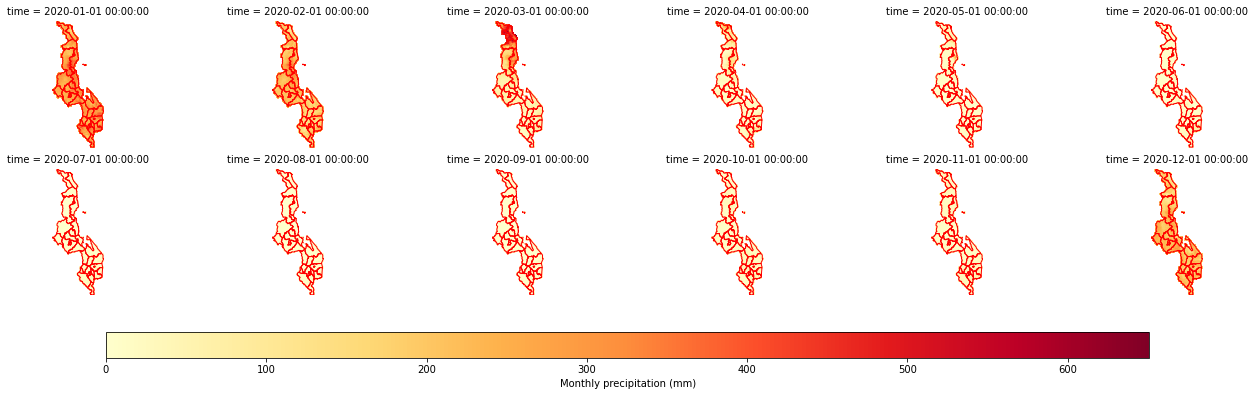

In [15]:
#show the data for each month of 2020, clipped to MWI
g=ds_clip.sel(time=ds_clip.time.dt.year.isin([2020])).precip.plot(
    col="time",
    col_wrap=6,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
        "label":"Monthly precipitation (mm)"
    },
    cmap="YlOrRd",
)

df_bound = gpd.read_file(adm2_bound_path)
for ax in g.axes.flat:
    df_bound.boundary.plot(linewidth=1, ax=ax, color="red")
    ax.axis("off")

In [16]:
ds_clip

<xarray.Dataset>
Dimensions:      (lat: 156, lon: 66, time: 481)
Coordinates:
  * time         (time) object 1981-01-01 00:00:00 ... 2021-01-01 00:00:00
  * lat          (lat) float64 -9.375 -9.425 -9.475 ... -17.02 -17.07 -17.12
  * lon          (lon) float64 32.68 32.73 32.78 32.83 ... 35.83 35.88 35.93
    spatial_ref  int64 0
Data variables:
    precip       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    latitude#axis:                            Y
    latitude#long_name:                       latitude
    latitude#standard_name:                   latitude
    latitude#units:                           degrees_north
    latitude#_FillValue:                      nan
    longitude#axis:                           X
    longitude#long_name:                      longitude
    longitude#standard_name:                  longitude
    longitude#units:                          degrees_east
    longitude#_FillValue:                     nan
    acknowledgements:                         The Climate Hazards Group Infra...
    comments:                                 time variable denotes the first...
    Conventions:                              CF-1.6
    creator_email:                            pete@geog.ucsb.edu
    creator_name:                             Pete Peterson
    date_created:                             2021-02-16
    documentation:                            http://pubs.usgs.gov/ds/832/
    faq:                                      http://chg-wiki.geog.ucsb.edu/w...
    ftp_url:                                  ftp://chg-ftpout.geog.ucsb.edu/...
    grid_mapping:                             spatial_ref
    history:                                  created by Climate Hazards Group
    institution:                              Climate Hazards Group.  Univers...
    reference:                                Funk, C.C., Peterson, P.J., Lan...
    title:                                    CHIRPS Version 2.0
    version:                                  Version 2.0
    website:                                  http://chg.geog.ucsb.edu/data/c...
    NETCDF_DIM_EXTRA:                         {time}
    NETCDF_DIM_time_DEF:                      [481.   5.]
    NETCDF_DIM_time_VALUES:                   [  366.   397.   425.   456.   ...
    precip#coordinates:                       spatial_ref
    precip#geostatial_lat_max:                50
    precip#geostatial_lat_min:                -50
    precip#geostatial_lon_max:                180
    precip#geostatial_lon_min:                -180
    precip#grid_mapping:                      spatial_ref
    precip#long_name:                         Climate Hazards group InfraRed ...
    precip#missing_value:                     -9999
    precip#standard_name:                     convective precipitation rate
    precip#time_step:                         month
    precip#units:                             mm/month
    precip#_FillValue:                        -9999
    spatial_ref#crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984...
    spatial_ref#geographic_crs_name:          WGS 84
    spatial_ref#GeoTransform:                 32.650003051757814 0.05 0.0 -17...
    spatial_ref#grid_mapping_name:            latitude_longitude
    spatial_ref#inverse_flattening:           298.257223563
    spatial_ref#longitude_of_prime_meridian:  0
    spatial_ref#prime_meridian_name:          Greenwich
    spatial_ref#reference_ellipsoid_name:     WGS 84
    spatial_ref#semi_major_axis:              6378137
    spatial_ref#semi_minor_axis:              6356752.314245179
    spatial_ref#spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984...
    time#axis:                                T
    time#calendar:                            gregorian
    time#standard_name:                       time
    time#units:                               days since 1980-01-01
    time#_FillValue:                          nan

In [17]:
#compute the rolling sum over three month period. Rolling sum works backwards, i.e. value for month 3 is sum of month 1 till 3
seas_len=3
ds_season=ds_clip.rolling(time=seas_len,min_periods=seas_len).sum().dropna(dim="time",how="all")

In [18]:
ds_season

<xarray.Dataset>
Dimensions:      (lat: 156, lon: 66, time: 479)
Coordinates:
  * time         (time) object 1981-03-01 00:00:00 ... 2021-01-01 00:00:00
  * lat          (lat) float64 -9.375 -9.425 -9.475 ... -17.02 -17.07 -17.12
  * lon          (lon) float64 32.68 32.73 32.78 32.83 ... 35.83 35.88 35.93
    spatial_ref  int64 0
Data variables:
    precip       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    latitude#axis:                            Y
    latitude#long_name:                       latitude
    latitude#standard_name:                   latitude
    latitude#units:                           degrees_north
    latitude#_FillValue:                      nan
    longitude#axis:                           X
    longitude#long_name:                      longitude
    longitude#standard_name:                  longitude
    longitude#units:                          degrees_east
    longitude#_FillValue:                     nan
    acknowledgements:                         The Climate Hazards Group Infra...
    comments:                                 time variable denotes the first...
    Conventions:                              CF-1.6
    creator_email:                            pete@geog.ucsb.edu
    creator_name:                             Pete Peterson
    date_created:                             2021-02-16
    documentation:                            http://pubs.usgs.gov/ds/832/
    faq:                                      http://chg-wiki.geog.ucsb.edu/w...
    ftp_url:                                  ftp://chg-ftpout.geog.ucsb.edu/...
    grid_mapping:                             spatial_ref
    history:                                  created by Climate Hazards Group
    institution:                              Climate Hazards Group.  Univers...
    reference:                                Funk, C.C., Peterson, P.J., Lan...
    title:                                    CHIRPS Version 2.0
    version:                                  Version 2.0
    website:                                  http://chg.geog.ucsb.edu/data/c...
    NETCDF_DIM_EXTRA:                         {time}
    NETCDF_DIM_time_DEF:                      [481.   5.]
    NETCDF_DIM_time_VALUES:                   [  366.   397.   425.   456.   ...
    precip#coordinates:                       spatial_ref
    precip#geostatial_lat_max:                50
    precip#geostatial_lat_min:                -50
    precip#geostatial_lon_max:                180
    precip#geostatial_lon_min:                -180
    precip#grid_mapping:                      spatial_ref
    precip#long_name:                         Climate Hazards group InfraRed ...
    precip#missing_value:                     -9999
    precip#standard_name:                     convective precipitation rate
    precip#time_step:                         month
    precip#units:                             mm/month
    precip#_FillValue:                        -9999
    spatial_ref#crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984...
    spatial_ref#geographic_crs_name:          WGS 84
    spatial_ref#GeoTransform:                 32.650003051757814 0.05 0.0 -17...
    spatial_ref#grid_mapping_name:            latitude_longitude
    spatial_ref#inverse_flattening:           298.257223563
    spatial_ref#longitude_of_prime_meridian:  0
    spatial_ref#prime_meridian_name:          Greenwich
    spatial_ref#reference_ellipsoid_name:     WGS 84
    spatial_ref#semi_major_axis:              6378137
    spatial_ref#semi_minor_axis:              6356752.314245179
    spatial_ref#spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984...
    time#axis:                                T
    time#calendar:                            gregorian
    time#standard_name:                       time
    time#units:                               days since 1980-01-01
    time#_FillValue:                          nan

<Figure size 432x288 with 0 Axes>

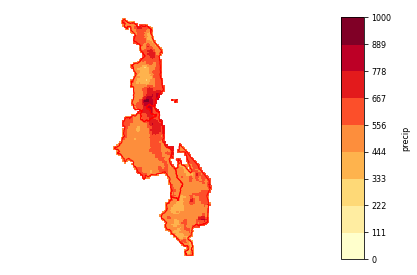

In [19]:
#plot the three month sum for NDJ 2019/2020
#dense spot seems to be a nature reserve that also looks more green on satellite imagery (Google Maps)
fig=plot_raster_boundaries_clip([ds_season.rio.set_spatial_dims(x_dim=config.LONGITUDE, y_dim=config.LATITUDE).rio.write_crs("EPSG:4326").sel(time=test_date)],adm1_bound_path,colp_num=1,forec_val="precip",cmap="YlOrRd",predef_bins=np.linspace(0,1000,10))

In [20]:
#define the years that are used to define the climatology. We use 1981-2010 since this is also the period used by IRI's seasonal forecasts
ds_season_climate=ds_season.sel(time=ds_season.time.dt.year.isin(range(1981,2011)))

In [21]:
ds_season_climate

<xarray.Dataset>
Dimensions:      (lat: 156, lon: 66, time: 358)
Coordinates:
  * time         (time) object 1981-03-01 00:00:00 ... 2010-12-01 00:00:00
  * lat          (lat) float64 -9.375 -9.425 -9.475 ... -17.02 -17.07 -17.12
  * lon          (lon) float64 32.68 32.73 32.78 32.83 ... 35.83 35.88 35.93
    spatial_ref  int64 0
Data variables:
    precip       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    latitude#axis:                            Y
    latitude#long_name:                       latitude
    latitude#standard_name:                   latitude
    latitude#units:                           degrees_north
    latitude#_FillValue:                      nan
    longitude#axis:                           X
    longitude#long_name:                      longitude
    longitude#standard_name:                  longitude
    longitude#units:                          degrees_east
    longitude#_FillValue:                     nan
    acknowledgements:                         The Climate Hazards Group Infra...
    comments:                                 time variable denotes the first...
    Conventions:                              CF-1.6
    creator_email:                            pete@geog.ucsb.edu
    creator_name:                             Pete Peterson
    date_created:                             2021-02-16
    documentation:                            http://pubs.usgs.gov/ds/832/
    faq:                                      http://chg-wiki.geog.ucsb.edu/w...
    ftp_url:                                  ftp://chg-ftpout.geog.ucsb.edu/...
    grid_mapping:                             spatial_ref
    history:                                  created by Climate Hazards Group
    institution:                              Climate Hazards Group.  Univers...
    reference:                                Funk, C.C., Peterson, P.J., Lan...
    title:                                    CHIRPS Version 2.0
    version:                                  Version 2.0
    website:                                  http://chg.geog.ucsb.edu/data/c...
    NETCDF_DIM_EXTRA:                         {time}
    NETCDF_DIM_time_DEF:                      [481.   5.]
    NETCDF_DIM_time_VALUES:                   [  366.   397.   425.   456.   ...
    precip#coordinates:                       spatial_ref
    precip#geostatial_lat_max:                50
    precip#geostatial_lat_min:                -50
    precip#geostatial_lon_max:                180
    precip#geostatial_lon_min:                -180
    precip#grid_mapping:                      spatial_ref
    precip#long_name:                         Climate Hazards group InfraRed ...
    precip#missing_value:                     -9999
    precip#standard_name:                     convective precipitation rate
    precip#time_step:                         month
    precip#units:                             mm/month
    precip#_FillValue:                        -9999
    spatial_ref#crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984...
    spatial_ref#geographic_crs_name:          WGS 84
    spatial_ref#GeoTransform:                 32.650003051757814 0.05 0.0 -17...
    spatial_ref#grid_mapping_name:            latitude_longitude
    spatial_ref#inverse_flattening:           298.257223563
    spatial_ref#longitude_of_prime_meridian:  0
    spatial_ref#prime_meridian_name:          Greenwich
    spatial_ref#reference_ellipsoid_name:     WGS 84
    spatial_ref#semi_major_axis:              6378137
    spatial_ref#semi_minor_axis:              6356752.314245179
    spatial_ref#spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984...
    time#axis:                                T
    time#calendar:                            gregorian
    time#standard_name:                       time
    time#units:                               days since 1980-01-01
    time#_FillValue:                          nan

In [22]:
#compute the thresholds for the lower tercile, i.e. below average, per season
#since we computed a rolling sum, each month represents a season
ds_season_climate_quantile=ds_season_climate.groupby(ds_season_climate.time.dt.month).quantile(0.33)

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [23]:
ds_season_climate_quantile

<xarray.Dataset>
Dimensions:   (lat: 156, lon: 66, month: 12)
Coordinates:
  * lat       (lat) float64 -9.375 -9.425 -9.475 -9.525 ... -17.02 -17.07 -17.12
  * lon       (lon) float64 32.68 32.73 32.78 32.83 ... 35.78 35.83 35.88 35.93
    quantile  float64 0.33
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip    (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

<Figure size 432x288 with 0 Axes>

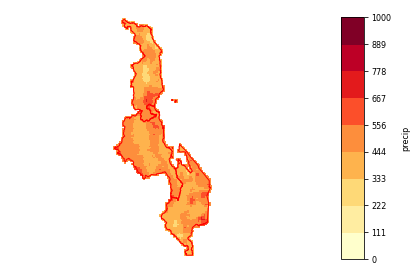

In [24]:
#plot the below average boundaries for the NDJ season
fig=plot_raster_boundaries_clip([ds_season_climate_quantile.rio.set_spatial_dims(x_dim=config.LONGITUDE, y_dim=config.LATITUDE).rio.write_crs("EPSG:4326").sel(month=1)],adm1_bound_path,colp_num=1,forec_val="precip",predef_bins=np.linspace(0,1000,10),cmap="YlOrRd")

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

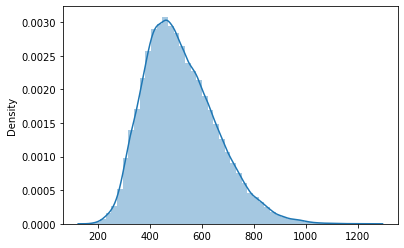

In [25]:
#plot all values and tercile boundaries to get a feeling for the general distribution and if the tercile boundaries make sense
sns.distplot(ds_season_climate.sel(time=ds_season_climate.time.dt.month==1).precip.values.flatten())

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

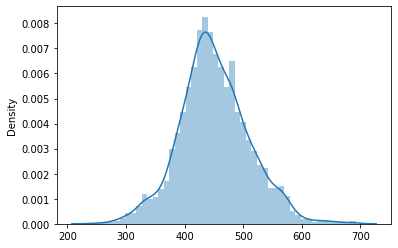

In [26]:
sns.distplot(ds_season_climate_quantile.sel(month=1).precip.values.flatten())

In [27]:
#determine the raster cells that have below-average precipitation, other cells are set to -999
list_ds_seass=[]
for s in np.unique(ds_season.time.dt.month):
    ds_seas_sel=ds_season.sel(time=ds_season.time.dt.month==s)
    #keep original values of cells that are either nan or have below average precipitation, all others are set to -999
    ds_seas_below=ds_seas_sel.where((ds_seas_sel.precip.isnull())|(ds_seas_sel.precip<=ds_season_climate_quantile.sel(month=s).precip),-999)#,drop=True)
    list_ds_seass.append(ds_seas_below)
ds_season_below=xr.concat(list_ds_seass,dim="time")        

In [28]:
ds_season_below

<xarray.Dataset>
Dimensions:      (lat: 156, lon: 66, time: 479)
Coordinates:
  * time         (time) object 1982-01-01 00:00:00 ... 2020-12-01 00:00:00
  * lat          (lat) float64 -9.375 -9.425 -9.475 ... -17.02 -17.07 -17.12
  * lon          (lon) float64 32.68 32.73 32.78 32.83 ... 35.83 35.88 35.93
    spatial_ref  int64 0
    quantile     float64 0.33
    month        (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
Data variables:
    precip       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    latitude#axis:                            Y
    latitude#long_name:                       latitude
    latitude#standard_name:                   latitude
    latitude#units:                           degrees_north
    latitude#_FillValue:                      nan
    longitude#axis:                           X
    longitude#long_name:                      longitude
    longitude#standard_name:                  longitude
    longitude#units:                          degrees_east
    longitude#_FillValue:                     nan
    acknowledgements:                         The Climate Hazards Group Infra...
    comments:                                 time variable denotes the first...
    Conventions:                              CF-1.6
    creator_email:                            pete@geog.ucsb.edu
    creator_name:                             Pete Peterson
    date_created:                             2021-02-16
    documentation:                            http://pubs.usgs.gov/ds/832/
    faq:                                      http://chg-wiki.geog.ucsb.edu/w...
    ftp_url:                                  ftp://chg-ftpout.geog.ucsb.edu/...
    grid_mapping:                             spatial_ref
    history:                                  created by Climate Hazards Group
    institution:                              Climate Hazards Group.  Univers...
    reference:                                Funk, C.C., Peterson, P.J., Lan...
    title:                                    CHIRPS Version 2.0
    version:                                  Version 2.0
    website:                                  http://chg.geog.ucsb.edu/data/c...
    NETCDF_DIM_EXTRA:                         {time}
    NETCDF_DIM_time_DEF:                      [481.   5.]
    NETCDF_DIM_time_VALUES:                   [  366.   397.   425.   456.   ...
    precip#coordinates:                       spatial_ref
    precip#geostatial_lat_max:                50
    precip#geostatial_lat_min:                -50
    precip#geostatial_lon_max:                180
    precip#geostatial_lon_min:                -180
    precip#grid_mapping:                      spatial_ref
    precip#long_name:                         Climate Hazards group InfraRed ...
    precip#missing_value:                     -9999
    precip#standard_name:                     convective precipitation rate
    precip#time_step:                         month
    precip#units:                             mm/month
    precip#_FillValue:                        -9999
    spatial_ref#crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984...
    spatial_ref#geographic_crs_name:          WGS 84
    spatial_ref#GeoTransform:                 32.650003051757814 0.05 0.0 -17...
    spatial_ref#grid_mapping_name:            latitude_longitude
    spatial_ref#inverse_flattening:           298.257223563
    spatial_ref#longitude_of_prime_meridian:  0
    spatial_ref#prime_meridian_name:          Greenwich
    spatial_ref#reference_ellipsoid_name:     WGS 84
    spatial_ref#semi_major_axis:              6378137
    spatial_ref#semi_minor_axis:              6356752.314245179
    spatial_ref#spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984...
    time#axis:                                T
    time#calendar:                            gregorian
    time#standard_name:                       time
    time#units:                               days

In [29]:
# #can be used to inspect the values that are below average
# with np.printoptions(threshold=np.inf):
#     print(np.unique(ds_season_below.sel(time=test_date)["precip"].values.flatten()[~np.isnan(ds_season_below.sel(time=test_date)["precip"].values.flatten())]))

In [30]:
#fraction of values with below average value. Should be around 0.33
ds_season_below_notnan=ds_season_below.precip.values[~np.isnan(ds_season_below.precip.values)]
np.count_nonzero(ds_season_below_notnan!=-999)/np.count_nonzero(ds_season_below_notnan)

0.31794414082721123

<Figure size 432x288 with 0 Axes>

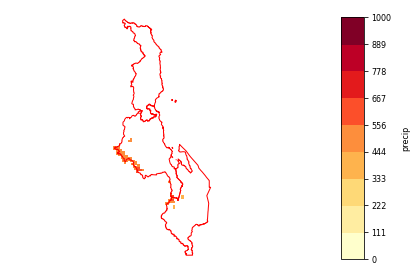

In [31]:
#plot the cells that had below-average rainfall in NDJ of 2019/2020
#there is goegraphical autocorrelation, i.e. cells close to each other share similair values, this is as it is supposed to be
fig=plot_raster_boundaries_clip([ds_season_below.where(ds_season_below.precip!=-999).rio.set_spatial_dims(x_dim=config.LONGITUDE, y_dim=config.LATITUDE).rio.write_crs("EPSG:4326").sel(time=test_date)],adm1_bound_path,colp_num=1,forec_val="precip",cmap="YlOrRd",predef_bins=np.linspace(0,1000,10))

In [32]:
def alldates_statistics(ds,raster_transform,adm_path):
    #compute statistics on level in adm_path for all dates in ds
    df_list=[]
    for date in ds.time.values:
        df=gpd.read_file(adm_path)
        ds_date=ds.sel(time=date)
        
        # compute the percentage of the admin area that has below average rainfall
        #set all values with below average rainfall to 1 and others to 0
        forecast_binary = np.where(ds_date.precip.values!=-999, 1, 0)
        #compute number of cells in admin region (sum) and number of cells in admin region with below average rainfall (count)
        bin_zonal = pd.DataFrame(
            zonal_stats(vectors=df, raster=forecast_binary, affine=raster_transform, stats=['count', 'sum'],nodata=np.nan))
        df['perc_threshold'] = bin_zonal['sum'] / bin_zonal['count'] * 100
        
        #same but then also including cells that only touch the admin region, i.e. don't have their cell within that region
        bin_zonal_touched = pd.DataFrame(
            zonal_stats(vectors=df, raster=forecast_binary, affine=raster_transform, all_touched=True, stats=['count', 'sum'],nodata=np.nan))
        df['perc_threshold_touched'] = bin_zonal_touched['sum'] / bin_zonal_touched['count'] * 100
        
        #return the value of the cell with the highest value within the admin region. 
        #In our case if this isn't -999 it indicates that at least one cell has below average rainfall
        df["max_cell_touched"] = pd.DataFrame(
        zonal_stats(vectors=df, raster=ds_date["precip"].values, affine=raster_transform, all_touched=True,nodata=np.nan))["max"]
        df["max_cell"] = pd.DataFrame(
        zonal_stats(vectors=df, raster=ds_date["precip"].values, affine=raster_transform, nodata=np.nan))["max"]
        
        df["date"]=pd.to_datetime(date.strftime("%Y-%m-%d"))
  
        df_list.append(df)
    df_hist=pd.concat(df_list)
    df_hist=df_hist.sort_values(by="date")
    #all admins that are not -999, have at least one cell with below average rainfall
    df_hist[f"below_average_touched"]=np.where(df_hist["max_cell_touched"]!=-999,1,0)
    df_hist[f"below_average_max"]=np.where(df_hist["max_cell"]!=-999,1,0)
        
    df_hist["date_str"]=df_hist["date"].dt.strftime("%Y-%m")
    df_hist['date_month']=df_hist.date.dt.to_period("M")
        
    return df_hist

In [33]:
#compute whether the maximum cell that touches an admin2 region has below average rainfall for each month since 2010
#have to write the crs for the transform to be correct!
df_belowavg_seas=alldates_statistics(ds_season_below.sel(time=ds_season_below.time.dt.year.isin(range(2000,2021))),ds_season_below.rio.set_spatial_dims(x_dim="lon",y_dim="lat").rio.write_crs("EPSG:4326").rio.transform(),adm2_bound_path)

In [34]:
# #quality check
# #check that all max touched values in df_belowavg_seas are also present in ds_season_below
# #this is to make sure all goes correctly with zonal_stats regarding crs's since it has happened that things go wrong there without insight why
# display(df_belowavg_seas[df_belowavg_seas.date==test_date_dtime])
# with np.printoptions(threshold=np.inf):
#     print(np.unique(ds_season_below.sel(time=test_date)["precip"].values.flatten()[~np.isnan(ds_season_below.sel(time=test_date)["precip"].values.flatten())]))

In [35]:
#percentage of area with below average rain
#TODO: decide which threshold to use
#could argue for 50%, i.e. majority
#could also argue for the threshold which results in around 1/3 of the occurences being below average, which is the definition of terciles. 
#in this case about the same but second method would change according to the data
#Don't know if large difference between adm regions
#Note: only including cells that have their centre within the region, do think this makes sense especially with the high resolution we got
for i in np.linspace(0,100,11):
    print(f"Fraction of adm2-date combinations where >={i}% of area received bel. avg. rain:","{:.2f}".format(len(df_belowavg_seas[df_belowavg_seas["perc_threshold"]>=i])/len(df_belowavg_seas)))

Fraction of adm2-date combinations where >=0.0% of area received bel. avg. rain: 1.00
Fraction of adm2-date combinations where >=10.0% of area received bel. avg. rain: 0.47
Fraction of adm2-date combinations where >=20.0% of area received bel. avg. rain: 0.42
Fraction of adm2-date combinations where >=30.0% of area received bel. avg. rain: 0.38
Fraction of adm2-date combinations where >=40.0% of area received bel. avg. rain: 0.35
Fraction of adm2-date combinations where >=50.0% of area received bel. avg. rain: 0.33
Fraction of adm2-date combinations where >=60.0% of area received bel. avg. rain: 0.30
Fraction of adm2-date combinations where >=70.0% of area received bel. avg. rain: 0.27
Fraction of adm2-date combinations where >=80.0% of area received bel. avg. rain: 0.25
Fraction of adm2-date combinations where >=90.0% of area received bel. avg. rain: 0.22
Fraction of adm2-date combinations where >=100.0% of area received bel. avg. rain: 0.17


In [36]:
#THIS is super interesting, that the area recieving below average rain clearly changed for 2010-2020 compared to 2000-2020
#Though would expect it to be the other way around, that more often areas recieve below average rain since 2010.. 
#percentage of area with below average rain
#TODO: decide which threshold to use
#could argue for 50%, i.e. majority
#could also argue for 30% as this results in around 1/3 of the occurences the area being below average, which is the definition of terciles. 
#Don't know if large difference between adm regions
#Note: only including cells that have their centre within the region, do think this makes sense especially with the high resolution we got
for i in np.linspace(0,100,11):
    print(f"Fraction of adm2-date combinations where >={i}% of area received bel. avg. rain 2010-2020:","{:.2f}".format(len(df_belowavg_seas[(df_belowavg_seas.date.dt.year>=2010)&(df_belowavg_seas["perc_threshold"]>=i)])/len(df_belowavg_seas[(df_belowavg_seas.date.dt.year>=2010)])))

Fraction of adm2-date combinations where >=0.0% of area received bel. avg. rain 2010-2020: 1.00
Fraction of adm2-date combinations where >=10.0% of area received bel. avg. rain 2010-2020: 0.43
Fraction of adm2-date combinations where >=20.0% of area received bel. avg. rain 2010-2020: 0.37
Fraction of adm2-date combinations where >=30.0% of area received bel. avg. rain 2010-2020: 0.33
Fraction of adm2-date combinations where >=40.0% of area received bel. avg. rain 2010-2020: 0.29
Fraction of adm2-date combinations where >=50.0% of area received bel. avg. rain 2010-2020: 0.27
Fraction of adm2-date combinations where >=60.0% of area received bel. avg. rain 2010-2020: 0.24
Fraction of adm2-date combinations where >=70.0% of area received bel. avg. rain 2010-2020: 0.22
Fraction of adm2-date combinations where >=80.0% of area received bel. avg. rain 2010-2020: 0.20
Fraction of adm2-date combinations where >=90.0% of area received bel. avg. rain 2010-2020: 0.17
Fraction of adm2-date combinati

In [37]:
#This is when assigning the whole adm2 region as below average when any cell touching has below average rainfall 
#--> logical that it is a larger fraction than the climatological 0.33
print("fraction of adm2s with at least one cell with below average rain:",len(df_belowavg_seas[df_belowavg_seas["below_average_max"]==1])/len(df_belowavg_seas))

fraction of adm2s with at least one cell with below average rain: 0.5553075396825397


In [38]:
#for now using 0.50 as threshold
df_belowavg_seas["below_average"]=np.where(df_belowavg_seas["perc_threshold"]>=50,1,0)

In [39]:
#Hmm surprised that there is such a large difference across months.. Would want them to all be around 0.33?
#compute fraction of values having below average per month
df_bavg_month=df_belowavg_seas.groupby(df_belowavg_seas.date.dt.month).sum()
df_bavg_month['fract_below']=df_bavg_month["below_average"]/df_belowavg_seas.groupby(df_belowavg_seas.date.dt.month).count()["below_average"]
df_bavg_month[["fract_below"]]

,fract_below
date,
1,0.275298
2,0.327381
3,0.345238
4,0.357143
5,0.303571
6,0.282738
7,0.294643
8,0.385417
9,0.372024


In [40]:
#compute fraction of values having below average per year
df_bavg_year=df_belowavg_seas.groupby(df_belowavg_seas.date.dt.year).sum()
df_bavg_year['fract_below']=df_bavg_year["below_average"]/df_belowavg_seas.groupby(df_belowavg_seas.date.dt.year).count()["below_average"]
df_bavg_year[["fract_below"]]

,fract_below
date,
2000,0.283854
2001,0.330729
2002,0.281250
2003,0.333333
2004,0.411458
2005,0.604167
2006,0.354167
2007,0.260417
2008,0.687500


In [41]:
#seems the deviation from 0.33 is not crazy large for any adm2 and not clear dependency on the size of the adm2
#compute fraction of values having below average per ADMIN2
df_bavg_adm2=df_belowavg_seas.groupby("ADM2_EN").sum()
df_bavg_adm2["fract_below"]=df_bavg_adm2["below_average"]/df_belowavg_seas.groupby("ADM2_EN").count()["below_average"]
df_bavg_adm2[["fract_below","Shape_Area"]]

,fract_below,Shape_Area
ADM2_EN,,
Balaka,0.297619,45.203513
Blantyre,0.345238,38.013424
Blantyre City,0.345238,5.022119
Chikwawa,0.293651,104.191073
Chiradzulu,0.309524,16.157509
Chitipa,0.317460,88.320185
Dedza,0.341270,79.371056
Dowa,0.361111,64.508543
Karonga,0.289683,70.929533


In [42]:
# #save to file
# #geometry takes long time to save, so remove that
# df_belowavg_seas.drop("geometry",axis=1).to_csv(os.path.join(country_data_processed_dir,"observed_belowavg_precip","chirps_seasonal_below_average_precipitation.csv"),index=False)

### CHIRPS monthly

In [43]:
#ds_clip already contains the monthly data, so don't need further preprocessing for that
#define the years that are used to define the climatology. We use 1981-2010 since this is also the period used by IRI's seasonal forecasts
ds_month_climate=ds_clip.sel(time=ds_clip.time.dt.year.isin(range(1981,2011)))

In [44]:
#compute the thresholds for the lower tercile, i.e. below average, per season
#since we computed a rolling sum, each month represents a season
ds_month_climate_quantile=ds_month_climate.groupby(ds_month_climate.time.dt.month).quantile(0.33,skipna=True)

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

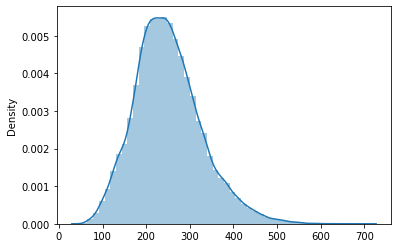

In [45]:
#plot all values and tercile boundaries to get a feeling for the general distribution and if the tercile boundaries make sense
sns.distplot(ds_month_climate.sel(time=ds_month_climate.time.dt.month==1).precip.values.flatten())

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

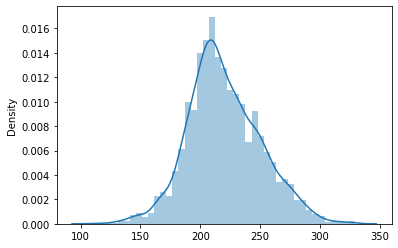

In [46]:
sns.distplot(ds_month_climate_quantile.sel(month=1).precip.values.flatten())

In [47]:
ds_month_climate_quantile

<xarray.Dataset>
Dimensions:   (lat: 156, lon: 66, month: 12)
Coordinates:
  * lat       (lat) float64 -9.375 -9.425 -9.475 -9.525 ... -17.02 -17.07 -17.12
  * lon       (lon) float64 32.68 32.73 32.78 32.83 ... 35.78 35.83 35.88 35.93
    quantile  float64 0.33
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip    (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

<Figure size 432x288 with 0 Axes>

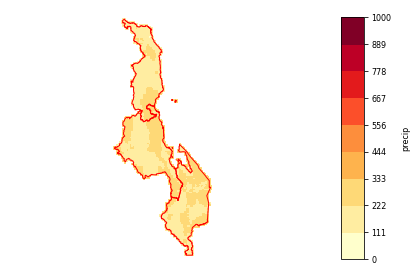

In [48]:
#plot the below average boundaries for the NDJ season
fig=plot_raster_boundaries_clip([ds_month_climate_quantile.rio.set_spatial_dims(x_dim=config.LONGITUDE, y_dim=config.LATITUDE).rio.write_crs("EPSG:4326").sel(month=1)],adm1_bound_path,colp_num=1,forec_val="precip",predef_bins=np.linspace(0,1000,10),cmap="YlOrRd")

In [49]:
#determine the raster cells that have below-average precipitation, other cells are set to -999
list_ds_months=[]
for s in np.unique(ds_clip.time.dt.month):
    ds_month_sel=ds_clip.sel(time=ds_clip.time.dt.month==s)
    #drop removes the dates with all nan values, i.e. no below average, but we dont want that
    ds_month_below=ds_month_sel.where((ds_month_sel.precip.isnull()) | (ds_month_sel.precip<=ds_month_climate_quantile.sel(month=s).precip) ,-999)
    list_ds_months.append(ds_month_below)
ds_month_below=xr.concat(list_ds_months,dim="time")        

In [50]:
# #can be used to inspect the values that are below average
# with np.printoptions(threshold=np.inf):
#     print(np.unique(ds_month_below.sel(time=test_month_date)["precip"].values.flatten()[~np.isnan(ds_month_below.sel(time=test_month_date)["precip"].values.flatten())]))

In [51]:
ds_month_below_notnan=ds_month_below.precip.values[~np.isnan(ds_month_below.precip.values)]
np.count_nonzero(ds_month_below_notnan!=-999)/np.count_nonzero(ds_month_below_notnan)

0.31441205435013486

<Figure size 432x288 with 0 Axes>

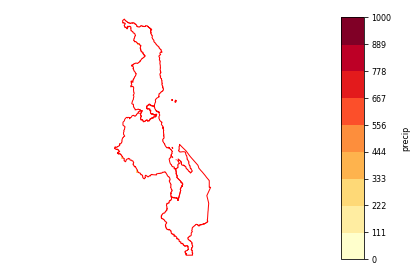

In [52]:
#not correct anymore cause using -999
#plot the cells that had below-average rainfall in DJF of 2019/2020
fig=plot_raster_boundaries_clip([ds_month_below.where(ds_month_below.precip!=-999).rio.set_spatial_dims(x_dim=config.LONGITUDE, y_dim=config.LATITUDE).rio.write_crs("EPSG:4326").sel(time=test_date)],adm1_bound_path,colp_num=1,forec_val="precip",cmap="YlOrRd",predef_bins=np.linspace(0,1000,10))

In [53]:
#compute whether the maximum cell that touches an admin2 region has below average rainfall for each month since 2010
df_belowavg_month=alldates_statistics(ds_month_below.sel(time=ds_month_below.time.dt.year.isin(range(2000,2021))),ds_month_below.rio.set_spatial_dims(x_dim="lon",y_dim="lat").rio.write_crs("EPSG:4326").rio.transform(),adm2_bound_path)

In [54]:
# #quality check
# #check that all max touched values in df_belowavg_month are also present in ds_month_below
# #this is to make sure all goes correctly with zonal_stats regarding crs's since it has happened that things go wrong there without insight why
# display(df_belowavg_month[df_belowavg_month.date==test_date_dtime])
# with np.printoptions(threshold=np.inf):
#     print(np.unique(ds_month_below.sel(time=test_month_date)["precip"].values.flatten()[~np.isnan(ds_month_below.sel(time=test_month_date)["precip"].values.flatten())]))

In [55]:
#percentage of area with below average rain
#TODO: decide which threshold to use
#could argue for 50%, i.e. majority
#could also argue for the threshold which results in around 1/3 of the occurences being below average, which is the definition of terciles. 
#in this case about the same but second method would change according to the data
#Don't know if large difference between adm regions
#Note: only including cells that have their centre within the region, do think this makes sense especially with the high resolution we got
for i in np.linspace(0,100,11):
    print(f"Fraction of adm2-date combinations where >={i}% of area received bel. avg. rain:","{:.2f}".format(len(df_belowavg_month[df_belowavg_month["perc_threshold"]>=i])/len(df_belowavg_month)))

Fraction of adm2-date combinations where >=0.0% of area received bel. avg. rain: 1.00
Fraction of adm2-date combinations where >=10.0% of area received bel. avg. rain: 0.46
Fraction of adm2-date combinations where >=20.0% of area received bel. avg. rain: 0.41
Fraction of adm2-date combinations where >=30.0% of area received bel. avg. rain: 0.38
Fraction of adm2-date combinations where >=40.0% of area received bel. avg. rain: 0.34
Fraction of adm2-date combinations where >=50.0% of area received bel. avg. rain: 0.32
Fraction of adm2-date combinations where >=60.0% of area received bel. avg. rain: 0.29
Fraction of adm2-date combinations where >=70.0% of area received bel. avg. rain: 0.27
Fraction of adm2-date combinations where >=80.0% of area received bel. avg. rain: 0.24
Fraction of adm2-date combinations where >=90.0% of area received bel. avg. rain: 0.20
Fraction of adm2-date combinations where >=100.0% of area received bel. avg. rain: 0.15


In [56]:
#This is when assigning the whole adm2 region as below average when any cell touching has below average rainfall 
#--> logical that it is a larger fraction than the climatological 0.33
print("fraction of adm2s with at least one cell with below average rain:",len(df_belowavg_month[df_belowavg_month["below_average_max"]==1])/len(df_belowavg_month))

fraction of adm2s with at least one cell with below average rain: 0.542906746031746


In [57]:
#for now using 0.50 as threshold
df_belowavg_month["below_average"]=np.where(df_belowavg_month["perc_threshold"]>=50,1,0)

In [58]:
#Hmm strange that there is such a large difference across months.. Should in theory all be 0.33?
#compute fraction of values having below average per month
df_bavg_month=df_belowavg_month.groupby(df_belowavg_month.date.dt.month).sum()
df_bavg_month['fract_below']=df_bavg_month["below_average"]/df_belowavg_month.groupby(df_belowavg_month.date.dt.month).count()["below_average"]
df_bavg_month[["fract_below"]]

,fract_below
date,
1,0.251488
2,0.367560
3,0.321429
4,0.282738
5,0.290179
6,0.284226
7,0.337798
8,0.339286
9,0.406250


In [59]:
#Hmm would have expected more deviation per year, e.g. I thought 2011 was very little rainfall year?
#compute fraction of values having below average per month
df_bavg_year=df_belowavg_month.groupby(df_belowavg_month.date.dt.year).sum()
df_bavg_year['fract_below']=df_bavg_year["below_average"]/df_belowavg_month.groupby(df_belowavg_month.date.dt.year).count()["below_average"]
df_bavg_year[["fract_below"]]

,fract_below
date,
2000,0.270833
2001,0.403646
2002,0.325521
2003,0.341146
2004,0.283854
2005,0.604167
2006,0.356771
2007,0.289062
2008,0.794271


In [60]:
#compute fraction of values having below average per ADMIN2
df_bavg_adm2=df_belowavg_month.groupby("ADM2_EN").sum()
df_bavg_adm2["fract_below"]=df_bavg_adm2["below_average"]/df_belowavg_month.groupby("ADM2_EN").count()["below_average"]
df_bavg_adm2[["fract_below"]]

,fract_below
ADM2_EN,
Balaka,0.250000
Blantyre,0.321429
Blantyre City,0.337302
Chikwawa,0.293651
Chiradzulu,0.297619
Chitipa,0.317460
Dedza,0.285714
Dowa,0.404762
Karonga,0.293651


In [8]:
# #save to file
# #geometry takes long time to save, so remove that
# df_belowavg_month.drop("geometry",axis=1).to_csv(os.path.join(country_data_processed_dir,"observed_belowavg_precip","chirps_monthly_below_average_precipitation.csv"),index=False)

### Quality checks CHIRPS data

#### Compare computed 3 month sum to that reported directly by CHIRPS
**Mailed them on 2-03 about this**

AAAAHHH There are large differences and I don't understand why... 
- The 3monthly data for Global and Africa don't correspond at all, also not when inspecting it in QGIS
- The 3monthly Global data clipped to MWI is not in the same range as the 3 month rolling sum
- The 3monthly Africa data clipped to MWI is in the same range, but doesn't equal the 3 month rolling sum


Leaving it as it is for now and summing the monthly data to 3 months ourselves since this is an easier to use format. However should at some point understand the differences.. 

In [ ]:
ds_chirps_3month=rioxarray.open_rasterio("../Data/chirps.3monthly.africa2019.111201.tiff",masked=True)
# ds_chirps_3month=rioxarray.open_rasterio("../Data/chirps.3monthly.africa2019.091011.tiff",masked=True)
# ds_chirps_3month=rioxarray.open_rasterio("../Data/chirps.3monthly.global2019.111201.tiff",masked=True)
# ds_chirps_3month=rioxarray.open_rasterio("../Data/chirps.3monthly.global2019.091011.tiff",masked=True)

In [ ]:
ds_chirps_3month=ds_chirps_3month.where(ds_chirps_3month.values!=-9999)

In [ ]:
ds_chirps_3month_mwi = ds_chirps_3month.rio.clip(df_bound.geometry.apply(mapping), df_bound.crs, all_touched=True)

In [ ]:
#3 monthly mean from chirps ftp
ds_chirps_3month_mwi.mean()

In [ ]:
#computed mean from our framework
ds_season.sel(time=cftime.DatetimeGregorian(2020, 1, 1, 0, 0, 0, 0)).precip.mean()
# ds_season.sel(time=cftime.DatetimeGregorian(2019, 11, 1, 0, 0, 0, 0)).precip.mean()

### IRI CAMS-OPI observed monthly terciles
**First wanted to use this source for computation of historical below avearge, but now we also got CHIRPS which has a higher resolution and is the ssame source as we used for computing the dry spells, I think it makes more sense to use that data**

The percentile data is downloaded from [IRI's Maproom](https://iridl.ldeo.columbia.edu/maproom/Global/Precipitation/Percentiles.html?bbox=bb%3A-20%3A-40%3A55%3A40%3Abb&T=Dec%202020)   
The percentiles are computed from the CAMS-OPI data. The period of 1981-2010 is used to define the climatology for each calendar month of the year. A dry mask is included for regions that receive less than 10 mm/month of precipitation on average in the 1981-2010 climatology for the month of the year.    

Somehow the resolution is very low, while the original CAMS-OPI dataset has a higher resolution. I don't know what the reason of this is though for the exploration it should be good enough


In [ ]:
# #would be great to do with opendap but couldn't find the right url.. 
# obs_tercile_url="http://iridl.ldeo.columbia.edu/ds:/SOURCES/.NOAA/.NCEP/.CPC/.CAMS_OPI/.v0208/.mean/.prcp/prcp_percentiles/dods"
# obs_tercile_url="http://iridl.ldeo.columbia.edu/ds:/SOURCES/.NOAA/.NCEP/.CPC/.CAMS_OPI/.v0208/.mean/.prcp/dup/T/%28Jan%201981%29%28Dec%202010%29RANGE/T/12/splitstreamgrid%5BT2%5D0.0/0.1/0.2/0.3/0.4/0.5/0.6/0.7/0.8/0.9/1.0/1.0/replacebypercentile%5Bpercentile%5Dboundedtablefunction/startcolormap/DATA/0/1/RANGE/white/sienna/sienna/0/VALUE/sienna/0.1/bandmax/tan/RGBdup/0.2/bandmax/white/white/0.8/bandmax/PaleGreen/RGBdup/0.9/bandmax/DarkGreen/RGBdup/1.0/bandmax/RGBdup/endcolormap//name//prcp_percentiles/def//long_name/%28Precipitation%20Percentiles%20%28brown%20below%2020th%20and%20green%20above%2080th%29%29def/SOURCES/.NOAA/.NCEP/.CPC/.CAMS_OPI/.v0208/.mean/.prcp/T/%28Jan%201981%29%28Dec%202010%29RANGE/T/%28days%20since%201960-01-01%29streamgridunitconvert/T/differential_mul/T/%28months%20since%201960-01-01%29streamgridunitconvert//units/%28mm/month%29def/yearly-climatology/10/flaglt%5BT%5DregridAverage//name//dry_mask/def/:ds/prcp_percentiles/dods"
# xr.open_dataset(obs_tercile_url)

In [ ]:
# #only need to run if you want to update the data
# obs_tercile_netcdf_url="http://iridl.ldeo.columbia.edu/ds:/SOURCES/.NOAA/.NCEP/.CPC/.CAMS_OPI/.v0208/.mean/.prcp/dup/T/%28Jan%201981%29%28Dec%202010%29RANGE/T/12/splitstreamgrid%5BT2%5D0.0/0.1/0.2/0.3/0.4/0.5/0.6/0.7/0.8/0.9/1.0/1.0/replacebypercentile%5Bpercentile%5Dboundedtablefunction/startcolormap/DATA/0/1/RANGE/white/sienna/sienna/0/VALUE/sienna/0.1/bandmax/tan/RGBdup/0.2/bandmax/white/white/0.8/bandmax/PaleGreen/RGBdup/0.9/bandmax/DarkGreen/RGBdup/1.0/bandmax/RGBdup/endcolormap//name//prcp_percentiles/def//long_name/%28Precipitation%20Percentiles%20%28brown%20below%2020th%20and%20green%20above%2080th%29%29def/SOURCES/.NOAA/.NCEP/.CPC/.CAMS_OPI/.v0208/.mean/.prcp/T/%28Jan%201981%29%28Dec%202010%29RANGE/T/%28days%20since%201960-01-01%29streamgridunitconvert/T/differential_mul/T/%28months%20since%201960-01-01%29streamgridunitconvert//units/%28mm/month%29def/yearly-climatology/10/flaglt%5BT%5DregridAverage//name//dry_mask/def/:ds/prcp_percentiles/data.nc"
# download_url(obs_tercile_netcdf_url,cams_tercile_path)

In [ ]:
terc_ds=xr.open_dataset(cams_tercile_path,decode_times=False)
terc_ds=terc_ds.rename({"X":"lon","Y":"lat"})
terc_ds=fix_calendar(terc_ds,timevar="T")
terc_ds = xr.decode_cf(terc_ds)
terc_ds = invert_latlon(terc_ds)

# AAARGHH apparently for this data I shouldn't adjust the longitude range, while for the rainfall forecasts it seemed essential
# and I have no clue what might cause this difference. Possibly also connected to the shapefile??
#This is essential for the rasterstats.zonal_stats, and I still don't fully understand what the format is that it needs
#But if it is not correct, it overlays the shapefile with another part of the world and thus the results can be completely off..
# terc_ds = change_longitude_range(terc_ds)

In [ ]:
#check again with this new methodology of computing the transform of the ds

In [ ]:
transform=terc_ds.rio.transform()

In [ ]:
transform

In [ ]:
terc_ds

In [ ]:
#check that all percentile values are in the expected range, i.e. 0-1
np.unique(terc_ds.prcp_percentiles.values.flatten()[~np.isnan(terc_ds.prcp_percentiles.values.flatten())])

In [ ]:
#plot the globe for one of the dates
plt.imshow(terc_ds.sel(T=cftime.Datetime360Day(2020, 12, 16, 0, 0, 0, 0))["prcp_percentiles"].values)

In [ ]:
#clip to country
df_bound = gpd.read_file(adm1_bound_path)
ds_clip = terc_ds.rio.set_spatial_dims(x_dim=config.LONGITUDE, y_dim=config.LATITUDE).rio.write_crs("EPSG:4326").rio.clip(df_bound.geometry.apply(mapping), df_bound.crs, all_touched=True)

In [ ]:
ds_clip

In [ ]:
#fraction of values with percentile <= 0.33, i.e. below average value. Should be around 0.33
ds_clip_notnan=ds_clip.prcp_percentiles.values[~np.isnan(ds_clip.prcp_percentiles.values)]
np.count_nonzero(ds_clip_notnan<=0.33)/np.count_nonzero(ds_clip_notnan)

In [ ]:
#show the data for each month of 2020, clipped to MWI
g=ds_clip.sel(T=ds_clip.T.dt.year.isin([2020])).prcp_percentiles.plot(
    col="T",
    col_wrap=3,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
        "label":"Monthly precipitation percentile (mm)"
    },
)

df_bound = gpd.read_file(adm1_bound_path)
for ax in g.axes.flat:
    df_bound.boundary.plot(linewidth=1, ax=ax, color="red")
    ax.axis("off")

In [ ]:
def alldates_statistics(ds,raster_transform,prob_threshold,adm_path):
    #compute statistics on level in adm_path for all dates in ds
    df_list=[]
    print(f"Number of forecasts: {len(ds.T)}")
    for date in ds.T.values:
        df=gpd.read_file(adm_path)
        ds_date=ds.sel(T=date)
        df["min_cell_touched"] = pd.DataFrame(
        zonal_stats(vectors=df, raster=ds_date["prcp_percentiles"].values, affine=raster_transform, all_touched=True,nodata=-999))["min"]
        df["date"]=pd.to_datetime(date.strftime("%Y-%m-%d"))
        df_list.append(df)
    df_hist=pd.concat(df_list)
    df_hist=df_hist.sort_values(by="date")

    for m in ["min_cell_touched"]:
        df_hist[f"{m}_se{prob_threshold}"]=np.where(df_hist[m]<=prob_threshold,1,0)
  
    df_hist["date_str"]=df_hist["date"].dt.strftime("%Y-%m")

    return df_hist

In [ ]:
#compute whether the minimum cell that touches an admin1 region has a percentile of 0.33 or below for each month since 2010
df_terc=alldates_statistics(terc_ds.sel(T=terc_ds.T.dt.year.isin(range(2010,2021))),terc_ds.rio.transform(),0.33,adm2_bound_path)
#remove the day from the date as it is monthly data and easier for further processing
df_terc["date_month"]=df_terc.date.dt.to_period("M")

`rasterstats.zonal_stats` overlays the raster data with the shapefile that I still don't fully understand. If e.g. the range of longitude coordinates is not as `zonal_stats` it expects, it overlays the shapefile with another part of the world.   
Thus, a double check that the `min_cell_touched` values in `df_terc` are one of the actual raw values in `ds_clip` on the same date

In [ ]:
ds_clip.sel(T=cftime.Datetime360Day(2020, 12, 16, 0, 0, 0, 0))["prcp_percentiles"].values

In [ ]:
# df_terc[df_terc.date=="2020-12-16"]

In [ ]:
#due to the methodology, this is larger than the fraction of raster cells with below average value
print(f"fraction of adm2s with below average value:",len(df_terc[df_terc["min_cell_touched_se0.33"]==1])/len(df_terc))

In [ ]:
#Hmm strange that there is such a large difference across months.. Should in theory all be 0.33?
#compute fraction of values having below average per month
df_terc_month=df_terc.groupby(df_terc.date.dt.month).sum()
df_terc_month['fract_below']=df_terc_month["min_cell_touched_se0.33"]/df_terc.groupby(df_terc.date.dt.month).count()["min_cell_touched_se0.33"]#/(len(df_terc.ADM2_EN.unique())*len(df_terc.date.dt.year.unique()))
df_terc_month[["fract_below"]]